---------------

**If any part of this notebook is used in your research, please cite with the reference found in** **[README.md](https://github.com/pysal/spaghetti#bibtex-citation).**


----------------

## Advanced `pysal.spaghetti` tutorial
### Creating and visualizing a `spaghetti.Network` object

**Author: James D. Gaboardi** **<jgaboardi@gmail.com>**

**This notebook is an advanced walk-through for:**

1. Exploring the attributes of network objects and point patterns
2. Understanding the difference between a network and its graph-theoretic representation
3. Performing spatial network analysis

In [1]:
%load_ext watermark
%watermark

2019-12-31T20:42:10-05:00

CPython 3.7.3
IPython 7.10.2

compiler   : Clang 9.0.0 (tags/RELEASE_900/final)
system     : Darwin
release    : 19.2.0
machine    : x86_64
processor  : i386
CPU cores  : 4
interpreter: 64bit


**In addtion to the base** **[spaghetti requirements](https://github.com/pysal/spaghetti/blob/master/requirements.txt)** **(and their dependecies), this notebook requires installations of:**

* [matplotlib](https://matplotlib.org)
    * `$ conda install matplotlib`

-----------------------

In [2]:
import esda
import libpysal
import matplotlib
import matplotlib.pyplot as plt
import numpy
import spaghetti
import warnings
%matplotlib inline
%watermark -iv

esda       2.1.1
libpysal   4.2.0
numpy      1.17.3
matplotlib 3.1.2
spaghetti  1.3.1



----------------

### 1. Instantiating a `spaghetti.Network` object
#### Instantiate the network from a `.shp` file

In [3]:
ntw = spaghetti.Network(in_data=libpysal.examples.get_path("streets.shp"))

------------------------------
### 2. Allocating observations (snapping points) to a network:

**A network is composed of a single topological representation of network elements (arcs and vertices) to which point patterns may be snapped.**

In [4]:
# Crimes
ntw.snapobservations(
    libpysal.examples.get_path("crimes.shp"), "crimes", attribute=True
)
# Schools
ntw.snapobservations(
    libpysal.examples.get_path("schools.shp"), "schools", attribute=False
)
ntw.pointpatterns

{'crimes': <spaghetti.network.PointPattern at 0x107278080>,
 'schools': <spaghetti.network.PointPattern at 0x120889048>}

**Attributes for every point pattern**

1. ``dist_snapped`` dict keyed by point id with the value as snapped distance from observation to network arc

In [5]:
ntw.pointpatterns["crimes"].dist_snapped[0]

221.5867616973843

2. ``dist_to_vertex`` dict keyed by pointid with the value being a dict in the form 
        {node: distance to vertex, node: distance to vertex}

In [6]:
ntw.pointpatterns["crimes"].dist_to_vertex[0]

{161: 83.70599311338093, 162: 316.8274480625799}

3. ``npoints`` point observations in set

In [7]:
ntw.pointpatterns["crimes"].npoints

287

4. ``obs_to_arc`` dict keyed by arc with the value being a dict in the form 
        {pointID:(x-coord, y-coord), pointID:(x-coord, y-coord), ... }

In [8]:
ntw.pointpatterns["crimes"].obs_to_arc[(161, 162)]

{0: (727919.2473619275, 875942.4986759046)}

5. ``obs_to_vertex`` list of incident network vertices to snapped observation points

In [9]:
ntw.pointpatterns["crimes"].obs_to_vertex[0]

161

6. ``points`` geojson like representation of the point pattern.  Includes properties if read with attributes=``True``

In [10]:
ntw.pointpatterns["crimes"].points[0]

{'coordinates': (727913.0000000029, 875720.9999999977), 'properties': [[1, 1]]}

7. ``snapped_coordinates`` dict keyed by pointid with the value being (x-coord, y-coord)

In [11]:
ntw.pointpatterns["crimes"].snapped_coordinates[0]

(727919.2473619275, 875942.4986759046)

**Counts per link (arc or edge) are important, but should not be precomputed since we have different representations of the network (spatial and graph currently).  (Relatively) Uniform segmentation still needs to be done.**

In [12]:
counts = ntw.count_per_link(ntw.pointpatterns["crimes"].obs_to_arc, graph=False)

In [13]:
orig_counts_per_link = sum(list(counts.values())) / float(len(counts.keys()))
orig_counts_per_link

2.682242990654206

-----------------------------

### 3. Network segmentation

#### Split network arcs into segments of 200 ([US feet is this case](https://github.com/pysal/libpysal/blob/master/libpysal/examples/geodanet/streets.prj))

In [14]:
n200 = ntw.split_arcs(200.0)

#### Calculate observations per link on the segmented network

In [15]:
counts = n200.count_per_link(n200.pointpatterns["crimes"].obs_to_arc, graph=False)
segm_counts_per_link = sum(counts.values()) / float(len(counts.keys()))
segm_counts_per_link

2.0354609929078014

---------------------

### 4. Extract `geopandas.GeoDataFrame` objects of the vertices and arcs

In [16]:
# 'full' unsegmented network
vertices_df, arcs_df = spaghetti.element_as_gdf(
    ntw, vertices=ntw.vertex_coords, arcs=ntw.arcs
)
# network segmented at 200-meter increments
vertices200_df, arcs200_df = spaghetti.element_as_gdf(
    n200, vertices=n200.vertex_coords, arcs=n200.arcs
)

----------------------

### 5. Visualization demonstration
* shapefile derived, unsegmented network with vertices in a larger, blue, semi-opaque form
* distance segmented network with small, red, fully opaque vertices

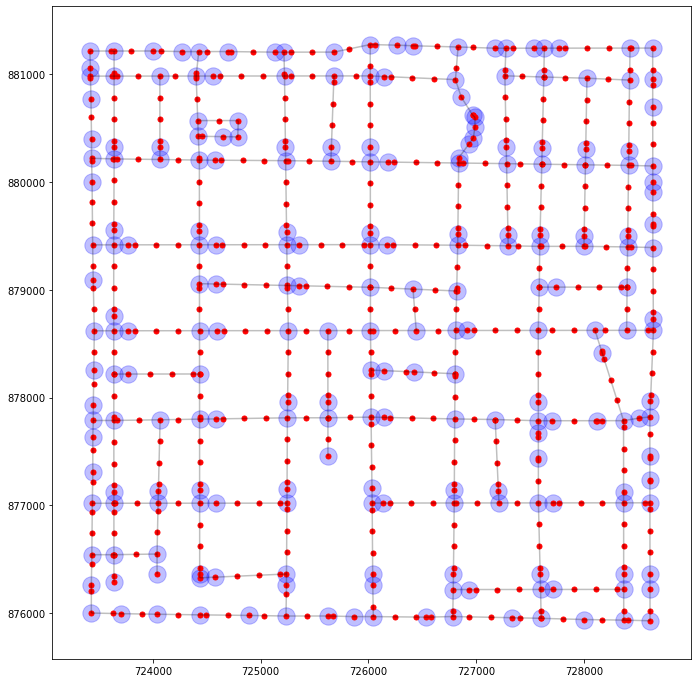

In [17]:
base = arcs_df.plot(color="k", alpha=0.25, figsize=(12, 12))
vertices_df.plot(ax=base, color="b", markersize=300, alpha=0.25)
vertices200_df.plot(ax=base, color="r", markersize=25, alpha=1.0)

---------------------------

### 6. Spatial Analysis with [pysal/esda](https://esda.readthedocs.io/en/latest/)

#### 6.1 Moran's *I* using the digitized network

In [18]:
# Compute the counts
counts = ntw.count_per_link(ntw.pointpatterns["crimes"].obs_to_arc, graph=False)

# Binary Adjacency
w = ntw.contiguityweights(graph=False)

# Build the y vector
arcs = w.neighbors.keys()
y = numpy.zeros(len(arcs))

for i, a in enumerate(arcs):
    if a in counts.keys():
        y[i] = counts[a]

# Moran's I
res = esda.moran.Moran(y, w, permutations=99)
print(dir(res))

['EI', 'EI_sim', 'I', 'VI_norm', 'VI_rand', 'VI_sim', '_Moran__calc', '_Moran__moments', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_statistic', 'by_col', 'n', 'p_norm', 'p_rand', 'p_sim', 'p_z_sim', 'permutations', 'seI_norm', 'seI_rand', 'seI_sim', 'sim', 'w', 'y', 'z', 'z2ss', 'z_norm', 'z_rand', 'z_sim']


#### 6.2 Moran's *I* using the graph representation to generate the *W*
* Note that we have to regenerate the counts per arc, since the graph will have less edges.

In [19]:
# Compute the counts
counts = ntw.count_per_link(ntw.pointpatterns["crimes"].obs_to_arc, graph=True)

# Binary Adjacency
w = ntw.contiguityweights(graph=True)

# Build the y vector
edges = w.neighbors.keys()
y = numpy.zeros(len(edges))

for i, e in enumerate(edges):
    if e in counts.keys():
        y[i] = counts[e]

# Moran's I
res = esda.moran.Moran(y, w, permutations=99)

print(dir(res))

['EI', 'EI_sim', 'I', 'VI_norm', 'VI_rand', 'VI_sim', '_Moran__calc', '_Moran__moments', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_statistic', 'by_col', 'n', 'p_norm', 'p_rand', 'p_sim', 'p_z_sim', 'permutations', 'seI_norm', 'seI_rand', 'seI_sim', 'sim', 'w', 'y', 'z', 'z2ss', 'z_norm', 'z_rand', 'z_sim']


#### 6.3 Moran's *I* using the segmented network and intensities instead of counts

In [20]:
# Compute the counts
counts = n200.count_per_link(n200.pointpatterns["crimes"].obs_to_arc, graph=False)

# Binary Adjacency
w = n200.contiguityweights(graph=False)

# Build the y vector and convert from raw counts to intensities
arcs = w.neighbors.keys()
y = numpy.zeros(len(n200.arcs))

for i, a in enumerate(arcs):
    if a in counts.keys():
        length = n200.arc_lengths[a]
        y[i] = float(counts[a]) / float(length)

# Moran's I
res = esda.moran.Moran(y, w, permutations=99)

print(dir(res))

['EI', 'EI_sim', 'I', 'VI_norm', 'VI_rand', 'VI_sim', '_Moran__calc', '_Moran__moments', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_statistic', 'by_col', 'n', 'p_norm', 'p_rand', 'p_sim', 'p_z_sim', 'permutations', 'seI_norm', 'seI_rand', 'seI_sim', 'sim', 'w', 'y', 'z', 'z2ss', 'z_norm', 'z_rand', 'z_sim']


----------------------------

### 7. Simulate a point pattern on the network

* Need to supply a count of the number of points and a distirbution (default is uniform).  Generally, this will not be called by the user, since the simulation will be used for Monte Carlo permutation.

In [21]:
npts = ntw.pointpatterns["crimes"].npoints
sim = ntw.simulate_observations(npts)
print(dir(sim))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'dist_to_vertex', 'npoints', 'obs_to_arc', 'obs_to_vertex', 'points', 'snapped_coordinates']


---------------------

### 8. Network-constrained observation cluster testing
#### *F*-function

In [22]:
fres = ntw.NetworkF(ntw.pointpatterns["crimes"], permutations=99)

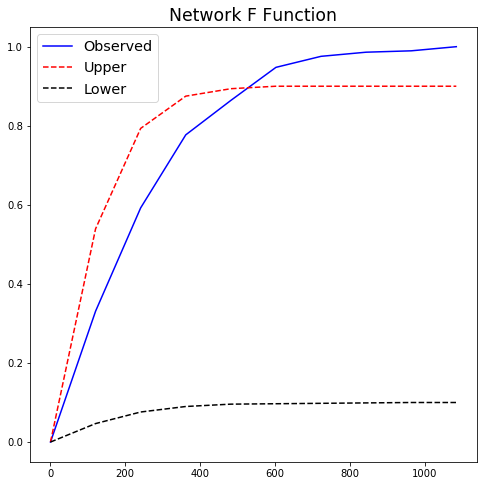

In [23]:
plt.figure(figsize=(8, 8))
plt.plot(fres.xaxis, fres.observed, "b-", linewidth=1.5, label="Observed")
plt.plot(fres.xaxis, fres.upperenvelope, "r--", label="Upper")
plt.plot(fres.xaxis, fres.lowerenvelope, "k--", label="Lower")
plt.legend(loc="best", fontsize="x-large")
plt.title("Network F Function", fontsize="xx-large")
plt.show()

#### *G*-function

In [24]:
gres = ntw.NetworkG(ntw.pointpatterns["crimes"], permutations=99)

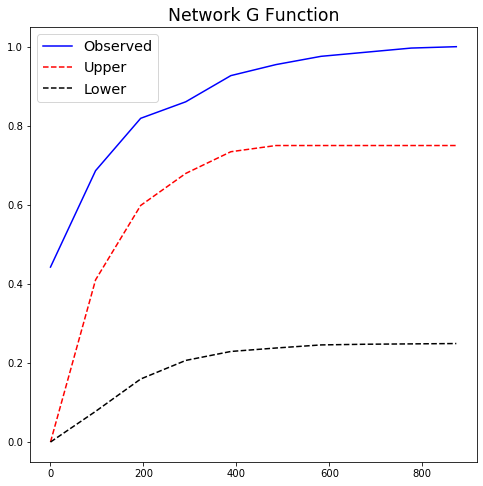

In [25]:
plt.figure(figsize=(8, 8))
plt.plot(gres.xaxis, gres.observed, "b-", linewidth=1.5, label="Observed")
plt.plot(gres.xaxis, gres.upperenvelope, "r--", label="Upper")
plt.plot(gres.xaxis, gres.lowerenvelope, "k--", label="Lower")
plt.legend(loc="best", fontsize="x-large")
plt.title("Network G Function", fontsize="xx-large")
plt.show()

#### *K*-function

In [26]:
warnings.filterwarnings("ignore", message="invalid value encountered")
kres = ntw.NetworkK(ntw.pointpatterns["crimes"], permutations=99)

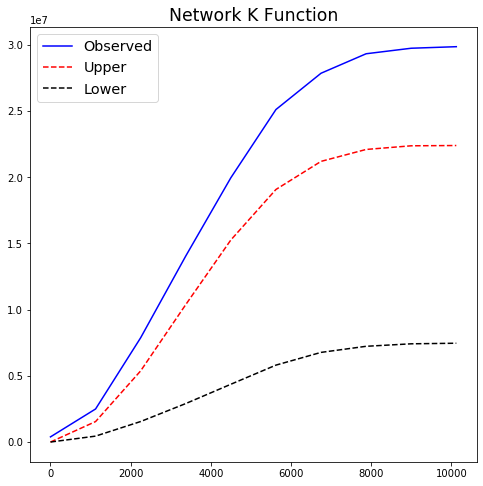

In [27]:
plt.figure(figsize=(8, 8))
plt.plot(kres.xaxis, kres.observed, "b-", linewidth=1.5, label="Observed")
plt.plot(kres.xaxis, kres.upperenvelope, "r--", label="Upper")
plt.plot(kres.xaxis, kres.lowerenvelope, "k--", label="Lower")
plt.legend(loc="best", fontsize="x-large")
plt.title("Network K Function", fontsize="xx-large")
plt.show()

-----------